# HelloWorld.jl

In [2]:
# import ModelingToolkit, our modeling framework package
using ModelingToolkit
# import DifferentialEquations.jl, this will allow us to solve the models we create.
using DifferentialEquations

In [3]:
# begin by defining our independent variable / time parameter, t
@variables t
# we also define the differential operator D = d/dt
D = Differential(t)

# this is how we define a variable of our model as a function of the independent variable t, with an initial condition
# (or 'default' value) of 1.0.
@variables x(t) = 1.0

# this is how we define a constant in our model.
@parameters a = 1.0


# We can then define an equation involving these terms.
Eq = Equation[D(x) ~ -a*x]


1-element Vector{Equation}:
 Differential(t)(x(t)) ~ -a*x(t)

If we now define some timespan (say 0.0 -> 1.0). 

In [4]:

@named sys = ODESystem(Eq, t, [x], [a])

Model sys with 1 equations
States (1):
  x(t) [defaults to 1.0]
Parameters (1):
  a [defaults to 1.0]

In [5]:
tspan = (0.0,10.0)
u0 = [x => 1.0]
ps = [a => 1.0]
prob = ODEProblem(sys, u0, tspan, ps)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 1-element Vector{Float64}:
 1.0

In [6]:
solution = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 19-element Vector{Float64}:
  0.0
  0.10001999200479662
  0.34208427873632274
  0.6553980290285384
  1.0312652902321524
  1.4709406498424789
  1.9659577002710475
  2.5116828197051655
  3.1005131845932916
  3.7267802882369727
  4.384652335738251
  5.0699090384067516
  5.779643487536935
  6.513468337242375
  7.274570876159992
  8.071453116363745
  8.918910524409286
  9.837942955834713
 10.0
u: 19-element Vector{Vector{Float64}}:
 [1.0]
 [0.9048193287657775]
 [0.7102883564034526]
 [0.5192354320104403]
 [0.35655575232768827]
 [0.2297097760377978]
 [0.1400224680615468]
 [0.08113256081377467]
 [0.04502714038509206]
 [0.024071202553369336]
 [0.012468055449568477]
 [0.006283629248389904]
 [0.0030902689323040575]
 [0.001483628395825723]
 [0.0006931308501843701]
 [0.0003124494757596515]
 [0.00013390814821315707]
 [5.343328199567361e-5]
 [4.543927265606355e-5]

let's now plot the results

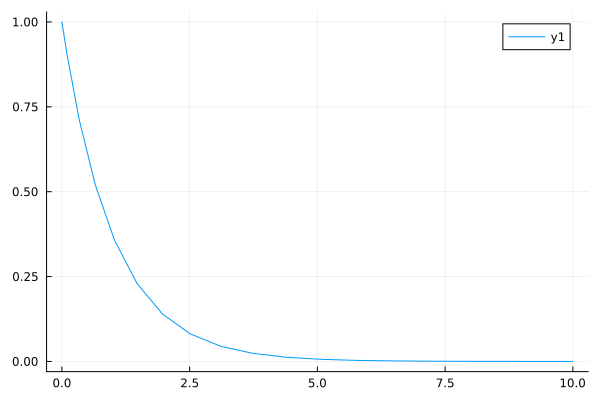

In [7]:
using Plots

plot(solution.t, solution[x])

# PlanarPendulum.jl

Let's bow look at actual physical system now: a planar (2D) pendulum.

Julia also lets us use unicode characters. For example, the mathematical constant Pi can be acessed by typing "\pi" (without the quotation marks.

In [8]:
π

π = 3.1415926535897...

In [9]:
p = @parameters m=1 g=9.81 L=0.5

3-element Vector{Num}:
 m
 g
 L

In [10]:
v = @variables F(t) x(t)=0.5 y(t)=0.0 vx(t)=0.0 vy(t)=0.0

5-element Vector{Num}:
      F(t)
  x(t)
  y(t)
 vx(t)
 vy(t)

In [15]:
pendulum_eqs = [m*D(vx) ~ (x/L)*F
            m*D(vy) ~ (y/L)*F
            D(x) ~ vx
            D(y) ~ vy
            x^2 + y^2 ~ L^2]

5-element Vector{Equation}:
 m*Differential(t)(vx(t)) ~ (F(t)*x(t)) / L
 m*Differential(t)(vy(t)) ~ (F(t)*y(t)) / L
 Differential(t)(x(t)) ~ vx(t)
 Differential(t)(y(t)) ~ vy(t)
 x(t)^2 + y(t)^2 ~ L^2

In [16]:
@named pendulum_sys = ODESystem(pendulum_eqs, t, v, p)

Model pendulum_sys with 5 equations
States (5):
  F(t)
  x(t) [defaults to 0.5]
  y(t) [defaults to 0.0]
  vx(t) [defaults to 0.0]
  vy(t) [defaults to 0.0]
Parameters (3):
  m [defaults to 1]
  g [defaults to 9.81]
  L [defaults to 0.5]

Do you notice anything about this system? Let's take a deeper look at the variables and equations..

In [17]:
states(pendulum_sys)

5-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 F(t)
 x(t)
 y(t)
 vx(t)
 vy(t)

In [19]:
equations(pendulum_sys)

5-element Vector{Equation}:
 m*Differential(t)(vx(t)) ~ (F(t)*x(t)) / L
 m*Differential(t)(vy(t)) ~ (F(t)*y(t)) / L
 Differential(t)(x(t)) ~ vx(t)
 Differential(t)(y(t)) ~ vy(t)
 x(t)^2 + y(t)^2 ~ L^2

In [21]:
parameters(pendulum_sys)

3-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 m
 g
 L

Interestingly enough, we don't actually have any explicit equation for F - the force acting back up along the pendulum. Is this an oversight perhaps? Surely we can't in general assume this to be a constant. We can instead take advantage of something ModelingToolkit refers to as 'Structural Simplify'. This uses the symbolic engine that underpins ModelingToolkit, as well as some other mathematical algorithms and tricks to reduce the 'order' of the model and simplify it down into its least complex form (and thus easiest to solve).

In [20]:
simp_pendulum_sys = structural_simplify(pendulum_sys)

Model pendulum_sys with 5 equations
States (5):
  y(t) [defaults to 0.0]
  vy(t) [defaults to 0.0]
  xˍt(t)
  x(t) [defaults to 0.5]
  F(t)
Parameters (3):
  m [defaults to 1]
  g [defaults to 9.81]
  L [defaults to 0.5]
Incidence matrix:5×7 SparseArrays.SparseMatrixCSC{Num, Int64} with 15 stored entries:
 ⋅  ×  ⋅  ×  ⋅  ⋅  ⋅
 ×  ⋅  ⋅  ⋅  ⋅  ×  ×
 ×  ⋅  ⋅  ⋅  ×  ⋅  ⋅
 ×  ⋅  ×  ⋅  ×  ⋅  ⋅
 ×  ⋅  ×  ×  ×  ×  ⋅

We

In [22]:
states(simp_pendulum_sys)

5-element Vector{Any}:
 y(t)
 vy(t)
 xˍt(t)
 x(t)
 F(t)

In [23]:
equations(simp_pendulum_sys)

5-element Vector{Equation}:
 Differential(t)(y(t)) ~ vy(t)
 Differential(t)(vy(t)) ~ vyˍt(t)
 0 ~ L^2 - (x(t)^2) - (y(t)^2)
 0 ~ -2vy(t)*y(t) - 2x(t)*xˍt(t)
 0 ~ -2(vy(t)^2) - 2(xˍt(t)^2) - 2x(t)*xˍtt(t) - 2vyˍt(t)*y(t)

In [24]:
parameters(simp_pendulum_sys)

3-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 m
 g
 L

In [25]:
# VanderPol.jl

model Van,DerPol "Van der Pol oscillator model"
   Real x(start = 1) "Descriptive string for x";   // x starts at 1
   Real y(start = 1) "Descriptive string for y";   // y starts at 1
   parameter Real lambda = 0.3;
equation
   der(x) = y;                         // This is the first equation
   der(y) = -x + lambda*(1 - x*x)*y;   /* The 2nd differential equation */
end VanDerPol;

Fritzson, Peter. Principles of Object-Oriented Modeling and Simulation with Modelica 3.3: A Cyber-Physical Approach (pp. 22-23). Wiley. Kindle Edition. 

In [29]:
function VanDerPol(;name=name)
    v = @variables begin
        x(t)=1 
        y(t)=1
    end
    p= @parameters begin
        λ=0.3
    end
    D = Differential(t)
    eqs = [
            D(x) ~ y
            D(y) ~ -x + λ*(1 - x*x)*y
        ]
    return ODESystem(eqs, t, v, p;name=name)
end

VanDerPol (generic function with 1 method)

In [30]:
@named vdp = VanDerPol()

Model vdp with 2 equations
States (2):
  x(t) [defaults to 1]
  y(t) [defaults to 1]
Parameters (1):
  λ [defaults to 0.3]

In [36]:
vdp_prob = ODEProblem(vdp, [], (0.0, 25), [])

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 25.0)
u0: 2-element Vector{Float64}:
 1.0
 1.0

In [37]:
vdp_sol = solve(vdp_prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 42-element Vector{Float64}:
  0.0
  0.09444155921128272
  0.309629301412104
  0.5947931682415029
  1.0272087231489304
  1.350861389002272
  1.8677516962291558
  2.5097663128038454
  3.094011268222774
  3.6480787323433335
  4.279461734181725
  4.826811307817099
  5.726418375092363
  ⋮
 17.90380736203529
 18.65602412236354
 19.34135698216835
 19.960174427419904
 20.610451903373203
 21.387928032927068
 22.112858143599883
 22.727650928934803
 23.312058106018096
 24.01966875182814
 24.75303951482844
 25.0
u: 42-element Vector{Vector{Float64}}:
 [1.0, 1.0]
 [1.0897650568937054, 0.8987547257336784]
 [1.2547662823377186, 0.6268103224592071]
 [1.3763093826519082, 0.2222305168892445]
 [1.3422668557468618, -0.36607674374503335]
 [1.1612016705494401, -0.7435587217072143]
 [0.6420946422915489, -1.2464390054124628]
 [-0.30306352790370766, -1.6228497771362917]
 [-1

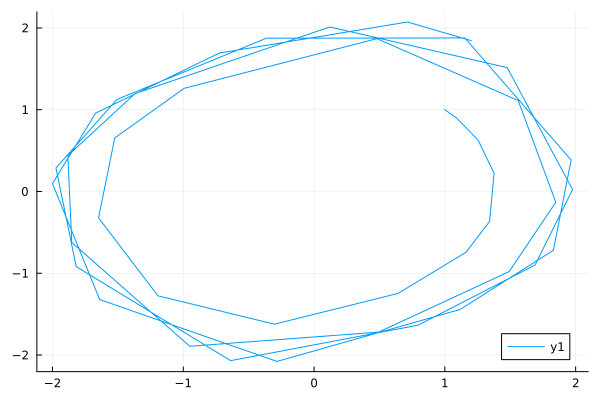

In [38]:
plot(vdp_sol[vdp.x], vdp_sol[vdp.y])